<a href="https://colab.research.google.com/github/ericodle/J_PlanktoNET/blob/main/pretrained_model_no_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pre-Process images

In [ ]:
import os
import cv2
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import random
import matplotlib.pyplot as plt
import torchvision.models as models


class CustomDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.image_paths = self.filter_images()

        # Define the image transformations
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
            #transforms.Normalize((0.4, 0.4, 0.4), (0.25, 0.25, 0.25))
            ])

    def filter_images(self):
        image_paths = []
        for filename in os.listdir(self.folder_path):
            image_path = os.path.join(self.folder_path, filename)
            if os.path.getsize(image_path) > 5000:  # Filter based on 5 KB size
                image_paths.append(image_path)
        return image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]

        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        return image

# Folder containing the images
folder_path = "/content/drive/MyDrive/D20230307T053258_IFCB108"

# Create a custom dataset
dataset = CustomDataset(folder_path)

# Create a PyTorch DataLoader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Visualize a random selection of processed images
num_images_to_visualize = 10
random_indices = random.sample(range(len(dataset)), num_images_to_visualize)

# Create a grid of subplots to display the images
fig, axes = plt.subplots(1, num_images_to_visualize, figsize=(15, 3))

# Visualize the images
for i, index in enumerate(random_indices):
    image = dataset[index]
    image = image.permute(1, 2, 0).numpy()  # Convert tensor to numpy array and change dimensions

    axes[i].imshow(image)
    axes[i].axis('off')

# Display the grid of images
plt.tight_layout()
plt.show()


ResNet50; kmeans clusters = 5; feature extract>PCA>Kmeans

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


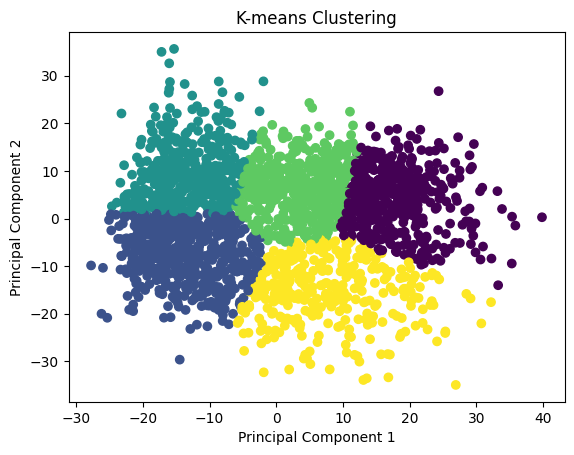

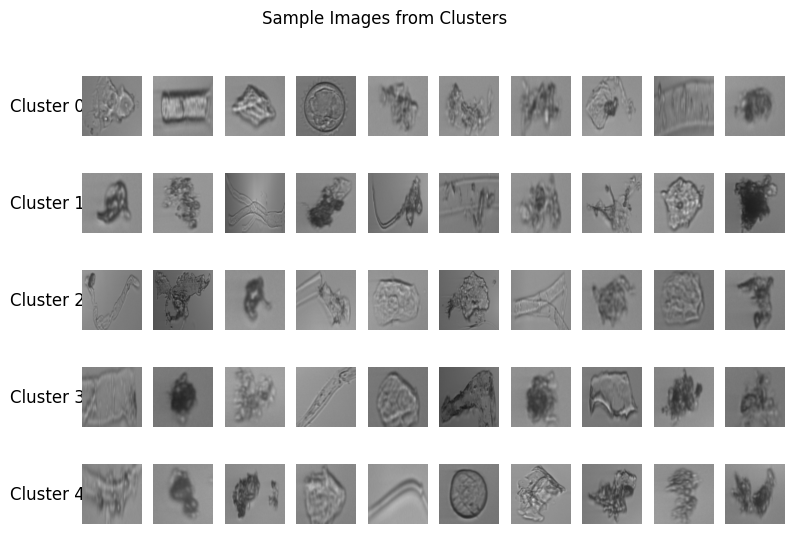

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pretrained ResNet-50 model
resnet = models.resnet50(pretrained=True)
resnet.to(device)
resnet.eval()

features = []

# Iterate over the dataset
for images in dataloader:
    images = images.to(device)

    # Extract features from the ResNet-50 model
    with torch.no_grad():
        outputs = resnet(images)

    features.append(outputs.cpu().detach())

# Concatenate the extracted features
features = torch.cat(features, dim=0)


import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert the extracted features to a numpy array
features_np = features.numpy()

# Apply PCA for dimensionality reduction (optional)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_np)

# Perform K-means clustering
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(reduced_features)

# Visualize the clustering results
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering')
plt.show()

# Get a sample of original images from each cluster
num_samples = 10
sample_images = []
for cluster_id in range(kmeans.n_clusters):
    cluster_indices = np.where(clusters == cluster_id)[0]
    sample_indices = np.random.choice(cluster_indices, size=num_samples, replace=False)
    sample_images.extend([dataset[index] for index in sample_indices])

# Visualize the sample images
fig, axs = plt.subplots(kmeans.n_clusters, num_samples + 1, figsize=(10, 6))
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Sample Images from Clusters')

for i, image in enumerate(sample_images):
    cluster_index = i // num_samples
    image_index = i % num_samples
    axs[cluster_index, image_index + 1].imshow(image.permute(1, 2, 0))
    axs[cluster_index, image_index + 1].axis('off')

    if image_index == 0:
        axs[cluster_index, 0].text(0, 0.5, f'Cluster {cluster_index}', fontsize=12, verticalalignment='center')
        axs[cluster_index, 0].axis('off')

plt.show()

VGG16; kmeans clusters = 5; model_output>Kmeans


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


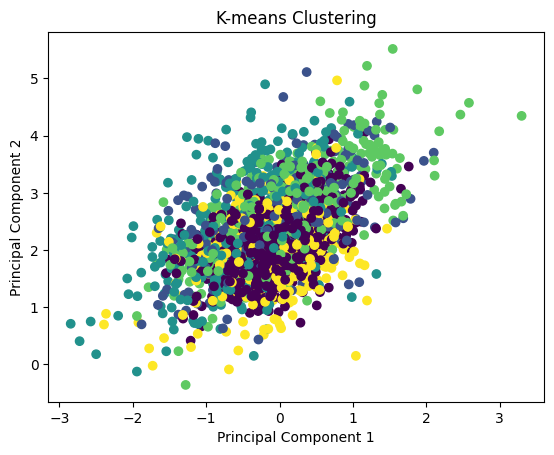

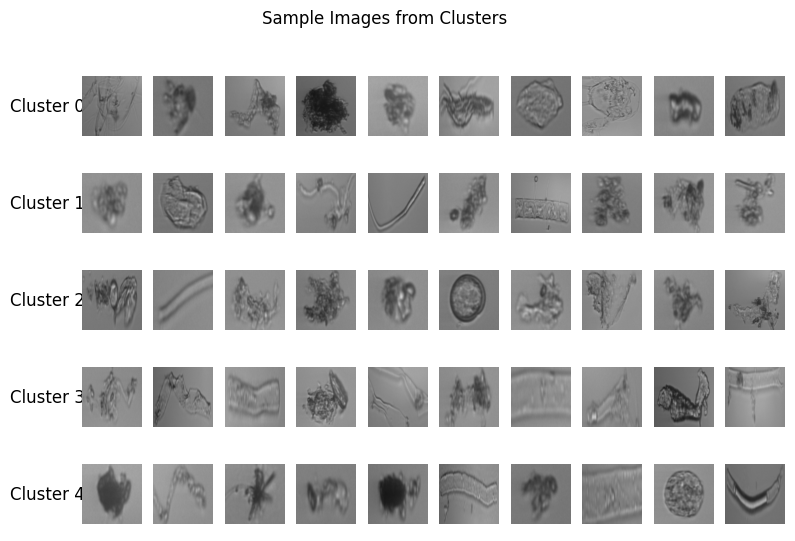

In [42]:
import torch
from torchvision import models
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pretrained VGG-16 model
vgg = models.vgg16(pretrained=True)
vgg.to(device)
vgg.eval()

# Define a function to extract features from an image
def extract_features(image):
    image = image.to(device)
    with torch.no_grad():
        features = vgg(image)
    return features.cpu().squeeze().numpy()

# Iterate over the dataset and extract features
image_features = []
for images in dataloader:
    features = extract_features(images)
    image_features.extend(features)

# Convert image_features to a NumPy array
features_np = np.array(image_features)


# Apply PCA for dimensionality reduction (optional)
#pca = PCA(n_components=2)
#reduced_features = pca.fit_transform(features_np)

# Perform K-means clustering
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(features_np)

# Visualize the clustering results
plt.scatter(features_np[:, 0], features_np[:, 1], c=clusters)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering')
plt.show()

# Get a sample of original images from each cluster
num_samples = 10
sample_images = []
for cluster_id in range(kmeans.n_clusters):
    cluster_indices = np.where(clusters == cluster_id)[0]
    sample_indices = np.random.choice(cluster_indices, size=num_samples, replace=False)
    sample_images.extend([dataset[index] for index in sample_indices])

# Visualize the sample images
fig, axs = plt.subplots(kmeans.n_clusters, num_samples + 1, figsize=(10, 6))
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Sample Images from Clusters')

for i, image in enumerate(sample_images):
    cluster_index = i // num_samples
    image_index = i % num_samples
    axs[cluster_index, image_index + 1].imshow(image.permute(1, 2, 0))
    axs[cluster_index, image_index + 1].axis('off')

    if image_index == 0:
        axs[cluster_index, 0].text(0, 0.5, f'Cluster {cluster_index}', fontsize=12, verticalalignment='center')
        axs[cluster_index, 0].axis('off')

plt.show()

VGG16; kmeans clusters = 5; model_output>PCA>Kmeans

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


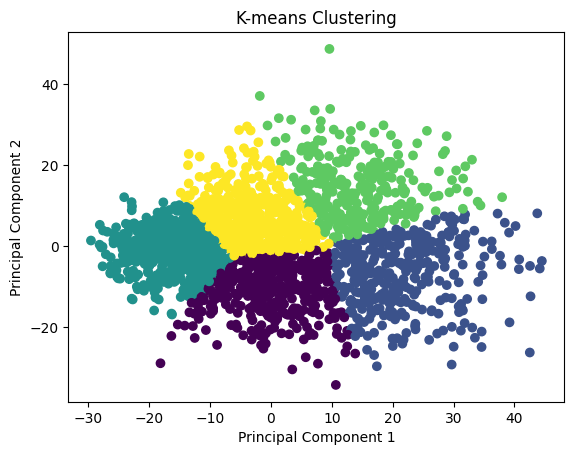

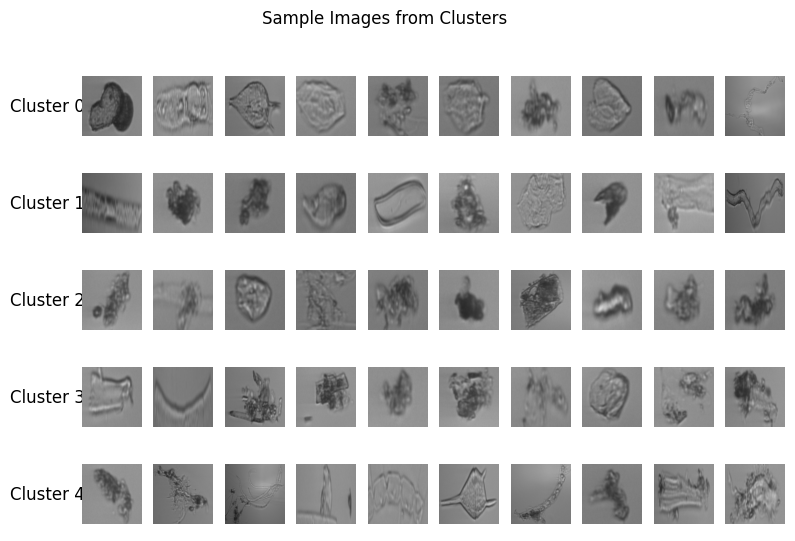

In [41]:
import torch
from torchvision import models
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pretrained VGG-16 model
vgg = models.vgg16(pretrained=True)
vgg.to(device)
vgg.eval()

# Define a function to extract features from an image
def extract_features(image):
    image = image.to(device)
    with torch.no_grad():
        features = vgg(image)
    return features.cpu().squeeze().numpy()

# Iterate over the dataset and extract features
image_features = []
for images in dataloader:
    features = extract_features(images)
    image_features.extend(features)

# Convert image_features to a NumPy array
features_np = np.array(image_features)


# Apply PCA for dimensionality reduction (optional)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_np)

# Perform K-means clustering
kmeans = KMeans(n_clusters = 5)
clusters = kmeans.fit_predict(reduced_features)

# Visualize the clustering results
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering')
plt.show()

# Get a sample of original images from each cluster
num_samples = 10
sample_images = []
for cluster_id in range(kmeans.n_clusters):
    cluster_indices = np.where(clusters == cluster_id)[0]
    sample_indices = np.random.choice(cluster_indices, size=num_samples, replace=False)
    sample_images.extend([dataset[index] for index in sample_indices])

# Visualize the sample images
fig, axs = plt.subplots(kmeans.n_clusters, num_samples + 1, figsize=(10, 6))
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Sample Images from Clusters')

for i, image in enumerate(sample_images):
    cluster_index = i // num_samples
    image_index = i % num_samples
    axs[cluster_index, image_index + 1].imshow(image.permute(1, 2, 0))
    axs[cluster_index, image_index + 1].axis('off')

    if image_index == 0:
        axs[cluster_index, 0].text(0, 0.5, f'Cluster {cluster_index}', fontsize=12, verticalalignment='center')
        axs[cluster_index, 0].axis('off')

plt.show()

U-Net

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


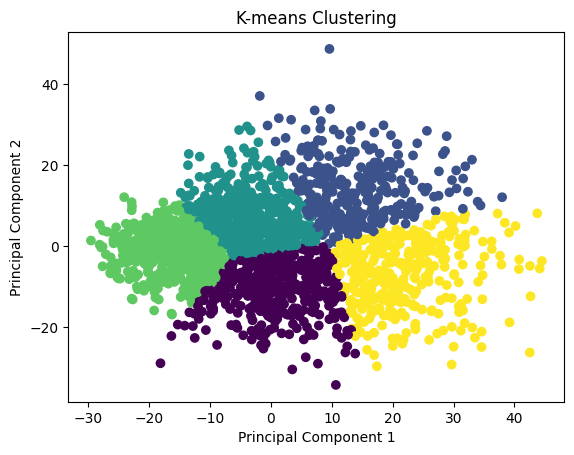

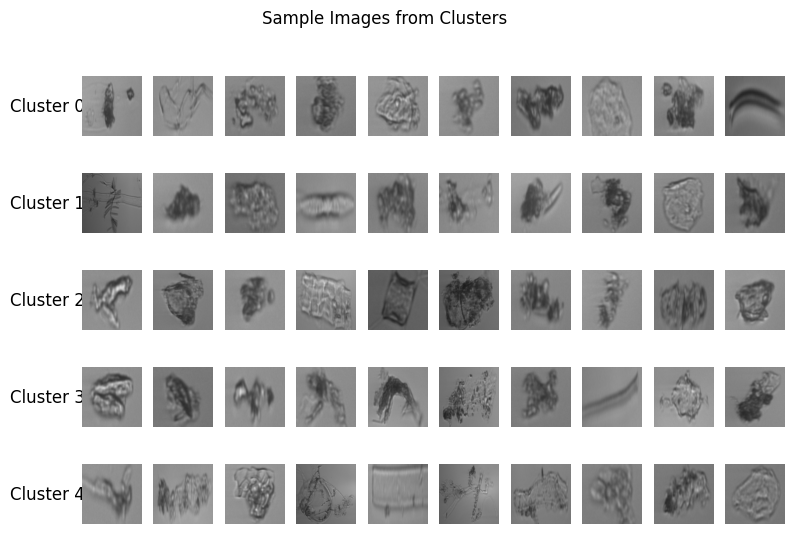

In [47]:
import torch
import torchvision.models as models
from torchvision.transforms import ToTensor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pretrained U-Net model
unet = models.segmentation.fcn_resnet50(pretrained=True)
unet.to(device)
unet.eval()

# Define a function to extract features from an image
def extract_features(image):
    image = image.to(device)
    with torch.no_grad():
        features = vgg(image)
    return features.cpu().squeeze().numpy()

# Iterate over the dataset and extract features
image_features = []
for images in dataloader:
    features = extract_features(images)
    image_features.extend(features)

# Convert image_features to a NumPy array
features_np = np.array(image_features)


# Apply PCA for dimensionality reduction (optional)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_np)

# Perform K-means clustering
kmeans = KMeans(n_clusters = 5)
clusters = kmeans.fit_predict(reduced_features)

# Visualize the clustering results
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering')
plt.show()

# Get a sample of original images from each cluster
num_samples = 10
sample_images = []
for cluster_id in range(kmeans.n_clusters):
    cluster_indices = np.where(clusters == cluster_id)[0]
    sample_indices = np.random.choice(cluster_indices, size=num_samples, replace=False)
    sample_images.extend([dataset[index] for index in sample_indices])

# Visualize the sample images
fig, axs = plt.subplots(kmeans.n_clusters, num_samples + 1, figsize=(10, 6))
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Sample Images from Clusters')

for i, image in enumerate(sample_images):
    cluster_index = i // num_samples
    image_index = i % num_samples
    axs[cluster_index, image_index + 1].imshow(image.permute(1, 2, 0))
    axs[cluster_index, image_index + 1].axis('off')

    if image_index == 0:
        axs[cluster_index, 0].text(0, 0.5, f'Cluster {cluster_index}', fontsize=12, verticalalignment='center')
        axs[cluster_index, 0].axis('off')

plt.show()